In [162]:
from scipy import io
from pathlib import Path

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import optax

from collections import defaultdict
import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams["font.family"] = "Times New Roman"

from dynamax.hidden_markov_model import CircHMMsT, LinearRegressionHMM, LogisticRegressionHMM
from dynamax.utils.plotting import gradient_cmap

from functools import partial
from jax import vmap

In [2]:
# load the data pickle
with open('ICLR_synth_data_1.pkl', 'rb') as f:
    data = pkl.load(f)

In [3]:
data.keys()

dict_keys(['train_emissions', 'test_emissions', 'train_true_states', 'test_true_states', 'inputs_batch_train', 'inputs_batch_test', 'true_params'])

In [4]:
true_params = data['true_params']

train_true_states = data['train_true_states']
test_true_states = data['test_true_states']

train_inputs = data['inputs_batch_train']
test_inputs = data['inputs_batch_test']

# circular datas emissions
circular_train_emission = data['train_emissions'].reshape(1000, 20, 1)
circular_test_emission = data['test_emissions'].reshape(500, 20, 1)

# binarized emissions if <0 is 0 else 1
binarized_train_emission = data['train_emissions'].reshape(1000, 20) > 0
binarized_test_emission = data['test_emissions'].reshape(500, 20) > 0

# linear is the same data but different model assumption

In [5]:
# A training cache to store all the models and their parameters
training_cache = defaultdict(dict)

# DS to store the models organized
class Model_Store:
    n_states: int
    fit_model: None
    fit_params: None
    lps: None

In [6]:
def train_hmms(model_class, num_states, emission_dim, input_dim, train_emissions, train_inputs):
    
    model = model_class(num_states, input_dim, emission_dim, transition_matrix_concentration=2, transition_matrix_stickiness= 10)
    parameters, properties = model.initialize(key=jr.PRNGKey(1))

    # Fit with SGD
    fit_params, lps = model.fit_sgd(params = parameters, 
                                    props = properties, 
                                    emissions = train_emissions, 
                                    inputs = train_inputs, 
                                    num_epochs = 5000, 
                                    optimizer = optax.adam(1e-3), 
                                    shuffle = False, 
                                    batch_size = 8)
    
    return model, fit_params, lps

In [7]:
train_inputs.shape, circular_train_emission.shape

((1000, 20, 2), (1000, 20, 1))

In [8]:
min_state, max_state = 2, 9
emission_dim, input_dim = 1, 2

for model_class in [CircHMMsT]:

    for num_states in range(min_state, max_state+1):
        print(f'Training: {model_class.__name__} - {num_states} states')

        model, fit_params, lps = train_hmms(model_class, num_states, emission_dim, input_dim, circular_train_emission, train_inputs)

        print(f"{lps[:10]}")

        t_store = Model_Store()
        t_store.n_states = num_states
        t_store.fit_model = model
        t_store.fit_params = fit_params
        t_store.lps = lps

        training_cache[model_class.__name__][num_states] = t_store


Training: CircHMMsT - 2 states
[2.0146296 2.0121393 2.009681  2.0072517 2.0048475 2.002468  2.0001087
 1.9977683 1.9954416 1.9931262]
Training: CircHMMsT - 3 states
[2.0141966 2.0116866 2.009206  2.0067546 2.0043297 2.0019307 1.9995561
 1.9972049 1.9948773 1.9925715]
Training: CircHMMsT - 4 states
[2.0138907 2.0113783 2.008902  2.0064642 2.0040603 2.00169   1.9993509
 1.9970435 1.9947644 1.9925123]
Training: CircHMMsT - 5 states
[2.0129795 2.0104659 2.0079863 2.0055397 2.0031228 2.0007317 1.9983637
 1.9960132 1.993677  1.9913536]
Training: CircHMMsT - 6 states
[2.0121758 2.0096571 2.0071704 2.0047114 2.0022688 1.9998392 1.9974209
 1.9950153 1.9926225 1.9902443]
Training: CircHMMsT - 7 states
[2.0111015 2.0085788 2.006094  2.0036426 2.001223  1.9988314 1.9964705
 1.9941361 1.9918287 1.9895471]
Training: CircHMMsT - 8 states
[2.0094607 2.0069315 2.0044312 2.001952  1.9994938 1.9970548 1.9946343
 1.9922315 1.989845  1.9874741]
Training: CircHMMsT - 9 states
[2.0076022 2.005079  2.0025856 

In [12]:
binarized_train_emission.shape

(1000, 20, 1)

In [13]:
min_state, max_state = 2, 9
emission_dim, input_dim = 1, 2

for model_class in [LogisticRegressionHMM]:

    for num_states in range(min_state, max_state+1):
        print(f'Training: {model_class.__name__} - {num_states} states')

        model, fit_params, lps = train_hmms(model_class, num_states, emission_dim, input_dim, binarized_train_emission, train_inputs)

        print(f"{lps[:10]}")

        t_store = Model_Store()
        t_store.n_states = num_states
        t_store.fit_model = model
        t_store.fit_params = fit_params
        t_store.lps = lps

        training_cache[model_class.__name__][num_states] = t_store


Training: LogisticRegressionHMM - 2 states
[0.67092746 0.67068684 0.67045456 0.6702309  0.67001516 0.6698072
 0.6696064  0.6694128  0.66922516 0.6690438 ]
Training: LogisticRegressionHMM - 3 states
[0.7519146  0.7505365  0.74918103 0.74784815 0.7465376  0.7452496
 0.74398357 0.7427394  0.74151677 0.74031574]
Training: LogisticRegressionHMM - 4 states
[0.71662056 0.7156981  0.71479756 0.713919   0.71306235 0.71222705
 0.71141255 0.7106187  0.7098453  0.7090914 ]
Training: LogisticRegressionHMM - 5 states
[0.6864126  0.6857658  0.6851343  0.684517   0.6839136  0.6833231
 0.68274546 0.68217987 0.68162614 0.68108404]
Training: LogisticRegressionHMM - 6 states
[0.68731093 0.68697083 0.68662924 0.686286   0.68594134 0.68559486
 0.6852469  0.684897   0.68454593 0.6841929 ]
Training: LogisticRegressionHMM - 7 states
[0.6896554  0.68937606 0.68909717 0.68881816 0.68853855 0.6882574
 0.6879747  0.6876894  0.68740135 0.68711007]
Training: LogisticRegressionHMM - 8 states
[0.6976841  0.6970901  0.

In [14]:
min_state, max_state = 2, 9
emission_dim, input_dim = 1, 2

for model_class in [LinearRegressionHMM]:

    for num_states in range(min_state, max_state+1):
        print(f'Training: {model_class.__name__} - {num_states} states')

        model, fit_params, lps = train_hmms(model_class, num_states, emission_dim, input_dim, circular_train_emission, train_inputs)

        print(f"{lps[:10]}")

        t_store = Model_Store()
        t_store.n_states = num_states
        t_store.fit_model = model
        t_store.fit_params = fit_params
        t_store.lps = lps

        training_cache[model_class.__name__][num_states] = t_store


Training: LinearRegressionHMM - 2 states
[1.9938612 1.9921776 1.9906267 1.9892012 1.9878892 1.9866786 1.9855583
 1.9845182 1.983548  1.9826379]
Training: LinearRegressionHMM - 3 states
[2.5849502 2.5729704 2.5611045 2.5493603 2.5377402 2.5262508 2.514897
 2.503683  2.4926157 2.4816985]
Training: LinearRegressionHMM - 4 states
[2.2237453 2.2167184 2.209865  2.203185  2.1966732 2.1903238 2.1841314
 2.1780896 2.1721952 2.1664426]
Training: LinearRegressionHMM - 5 states
[2.006898  2.0023282 1.9978981 1.9936073 1.9894519 1.9854274 1.9815297
 1.9777547 1.9740981 1.970556 ]
Training: LinearRegressionHMM - 6 states
[1.9023304 1.8997946 1.8973399 1.8949614 1.8926531 1.8904064 1.8882152
 1.8860717 1.8839705 1.8819069]
Training: LinearRegressionHMM - 7 states
[2.0797908 2.0745087 2.0693836 2.064413  2.059593  2.0549176 2.0503812
 2.0459785 2.0417037 2.037554 ]
Training: LinearRegressionHMM - 8 states
[2.1718922 2.1649067 2.1580994 2.151469  2.1450067 2.1387026 2.132549
 2.1265385 2.1206665 2.114

In [ ]:
# SGD
plt.figure(figsize=(8, 6))

for x in range(2,7):
    plt.plot(training_cache["CircHMMsT"][x].lps, "--")
plt.legend(range(2, 7))
# plt.ylim(-2, 2)
plt.xlim(0, 5000)
plt.title("SGD Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.savefig("sgd_loss.eps", format="eps")

Text(0.5, 1.0, 'SGD Loss of 5 states model')

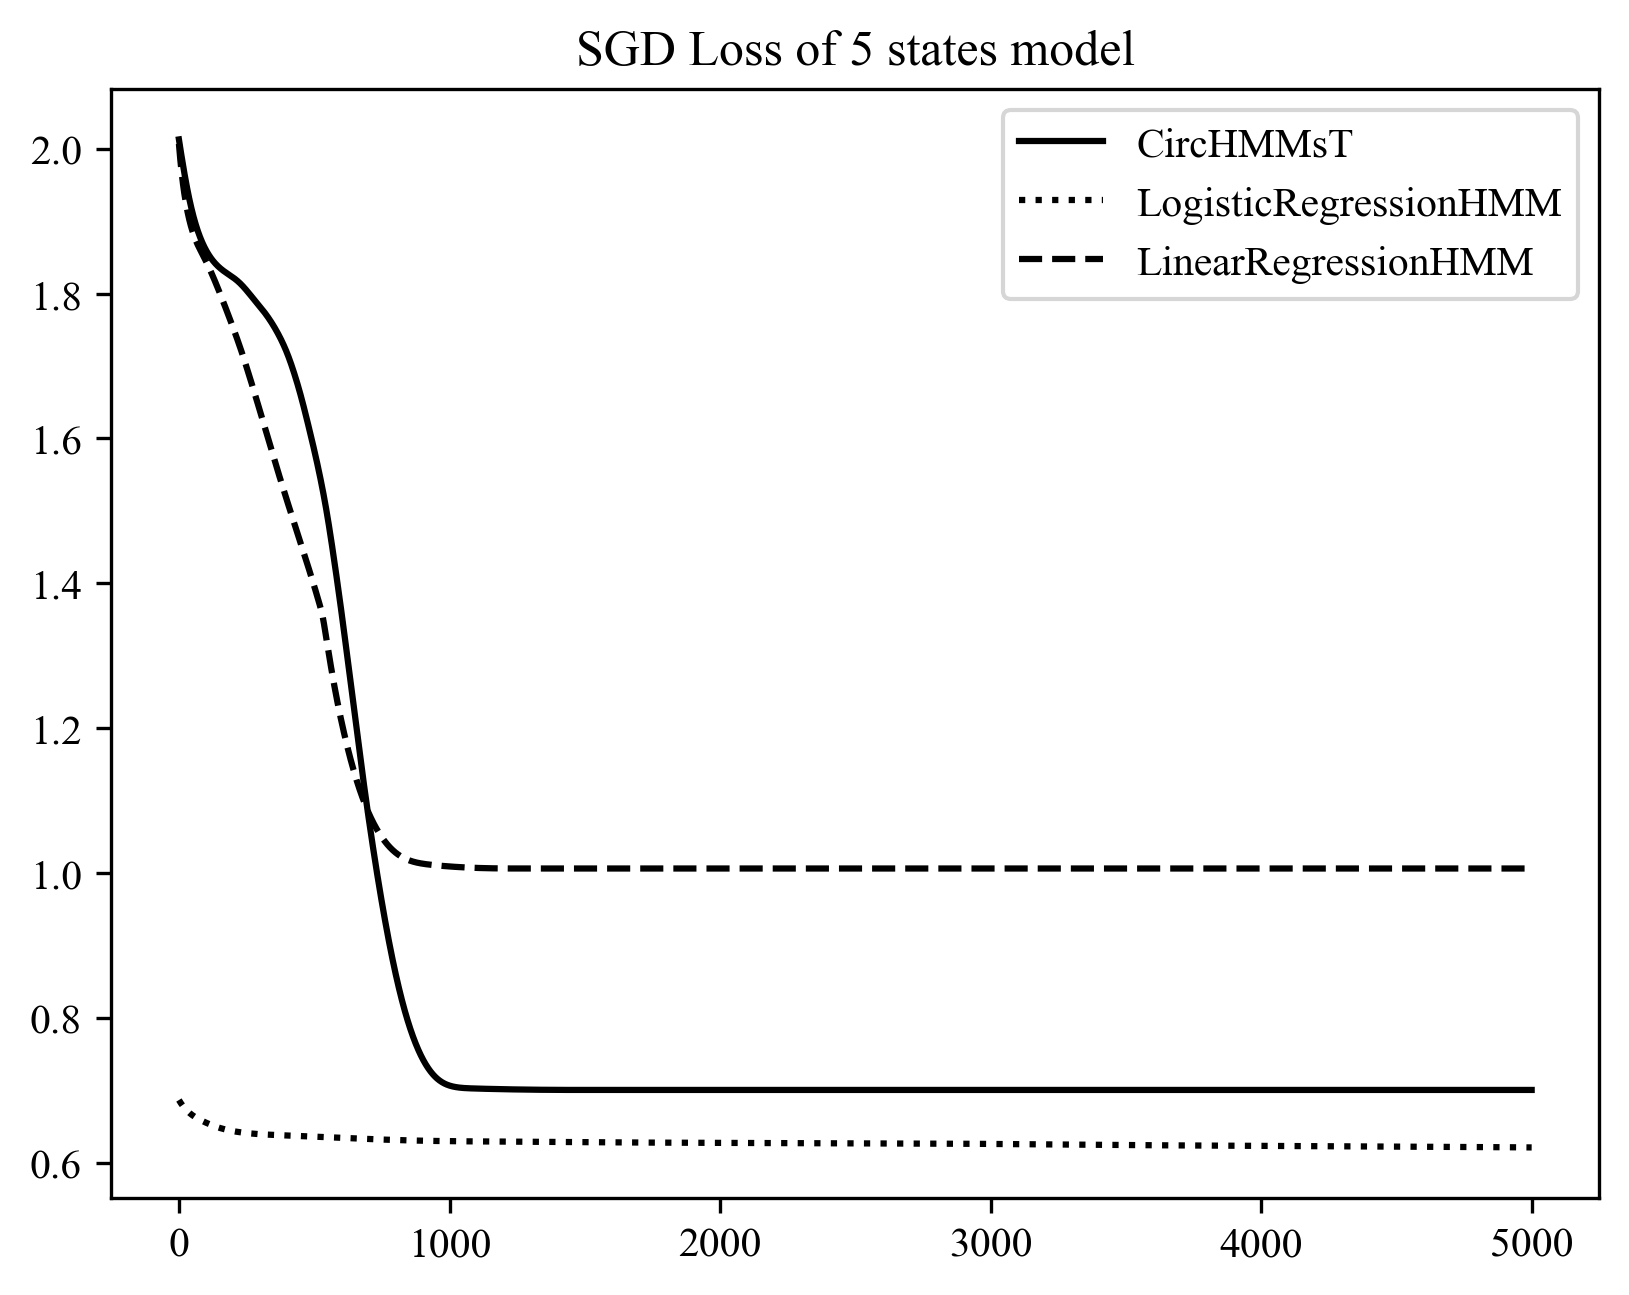

In [177]:
state = 5
plt.figure(dpi=300)
plt.plot(training_cache["CircHMMsT"][state].lps, "k-")
plt.plot(training_cache["LogisticRegressionHMM"][state].lps, "k:")
plt.plot(training_cache["LinearRegressionHMM"][state].lps, "k--")
plt.legend(["CircHMMsT", "LogisticRegressionHMM", "LinearRegressionHMM"])

plt.title("SGD Loss of 5 states model")

In [18]:
training_cache

defaultdict(dict,
            {'CircHMMsT': {2: <__main__.Model_Store at 0x7fe66c57af20>,
              3: <__main__.Model_Store at 0x7fe684615720>,
              4: <__main__.Model_Store at 0x7fe618345720>,
              5: <__main__.Model_Store at 0x7fe5e024e5c0>,
              6: <__main__.Model_Store at 0x7fe5a44cf1c0>,
              7: <__main__.Model_Store at 0x7fe6182bd180>,
              8: <__main__.Model_Store at 0x7fe53c6fec80>,
              9: <__main__.Model_Store at 0x7fe53c71ae60>},
             'LogisticRegressionHMM': {2: <__main__.Model_Store at 0x7fe504117bb0>,
              3: <__main__.Model_Store at 0x7fe4e5fdee60>,
              4: <__main__.Model_Store at 0x7fe4e5b9c7f0>,
              5: <__main__.Model_Store at 0x7fe504460f40>,
              6: <__main__.Model_Store at 0x7fe4e5961780>,
              7: <__main__.Model_Store at 0x7fe5046f7eb0>,
              8: <__main__.Model_Store at 0x7fe504219cf0>,
              9: <__main__.Model_Store at 0x7fe4e537fca0>}

In [28]:
# Save the training cache using cloudpickle
# import cloudpickle as cp

# with open('ICLR_synth_1_trained_cache.pkl', 'wb') as f:
#     cp.dump(training_cache, f)

In [37]:
test_inputs.shape

(500, 20, 2)

In [38]:
circular_test_emission.shape

(500, 20, 1)

In [44]:
validation_log_probs = defaultdict(dict)

for model_name in training_cache.keys():
    log_prob_sts = []
    for st in range(2,9+1):
        print(f"Cross-validating {model_name} with {st} states")
        curr_model = training_cache[model_name][st]
        log_probs = []
        for i in range(500):
            log_probs.append(curr_model.fit_model.marginal_log_prob(curr_model.fit_params, circular_test_emission[i], test_inputs[i]))
        log_prob_sts.append(log_probs)

    validation_log_probs[model_name] = np.array(log_prob_sts)

Cross-validating CircHMMsT with 2 states
Cross-validating CircHMMsT with 3 states
Cross-validating CircHMMsT with 4 states
Cross-validating CircHMMsT with 5 states
Cross-validating CircHMMsT with 6 states
Cross-validating CircHMMsT with 7 states
Cross-validating CircHMMsT with 8 states
Cross-validating CircHMMsT with 9 states
Cross-validating LogisticRegressionHMM with 2 states
Cross-validating LogisticRegressionHMM with 3 states
Cross-validating LogisticRegressionHMM with 4 states
Cross-validating LogisticRegressionHMM with 5 states
Cross-validating LogisticRegressionHMM with 6 states
Cross-validating LogisticRegressionHMM with 7 states
Cross-validating LogisticRegressionHMM with 8 states
Cross-validating LogisticRegressionHMM with 9 states
Cross-validating LinearRegressionHMM with 2 states
Cross-validating LinearRegressionHMM with 3 states
Cross-validating LinearRegressionHMM with 4 states
Cross-validating LinearRegressionHMM with 5 states
Cross-validating LinearRegressionHMM with 6 

In [43]:
validation_log_probs["CircHMMsT"].shape

(7, 500)

Text(0.5, 1.0, 'Validation Log Probs')

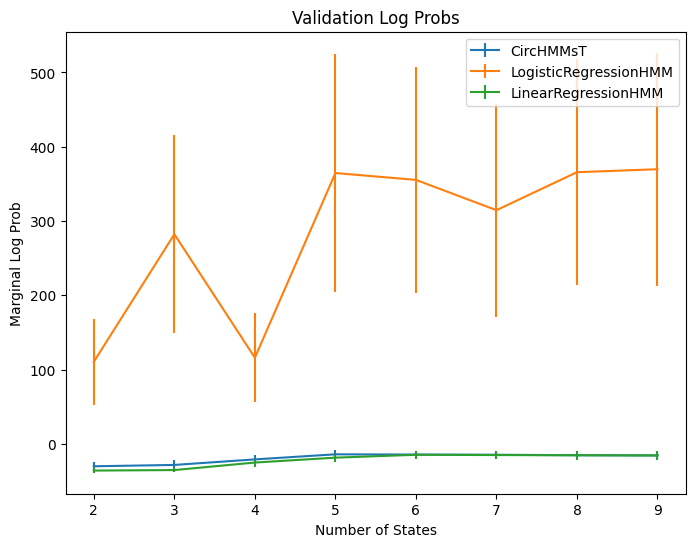

In [65]:
# put this into a dataframe and plot the mean and variance of the log probs for each model
# Each model is a line
# x-axis is the number of states
# y-axis is the log prob

# Plot the log probs
plt.figure(figsize=(8, 6))

for model_name in validation_log_probs.keys():
    mean_log_probs = np.mean(validation_log_probs[model_name], axis=1)
    std_log_probs = np.std(validation_log_probs[model_name], axis=1)
    plt.errorbar(range(2, 10), mean_log_probs, yerr=std_log_probs, label=model_name)

plt.legend()
plt.xlabel("Number of States")
plt.ylabel("Marginal Log Prob")
plt.title("Validation Log Probs")

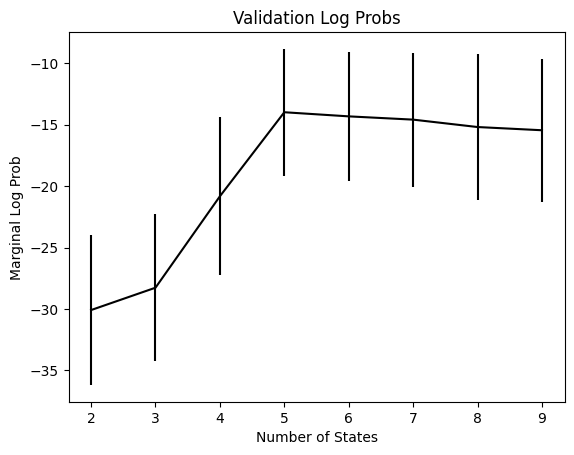

In [79]:
# plt.plot(validation_log_probs["CircHMMsT"].mean(axis=1))
plt.errorbar(range(0, 8), validation_log_probs["CircHMMsT"].mean(axis=1), c="k", yerr=validation_log_probs["CircHMMsT"].std(axis=1))
plt.xticks(range(0, 8), range(2, 10))

plt.xlabel("Number of States")
plt.ylabel("Marginal Log Prob")
plt.title("Validation Log Probs")

plt.show()


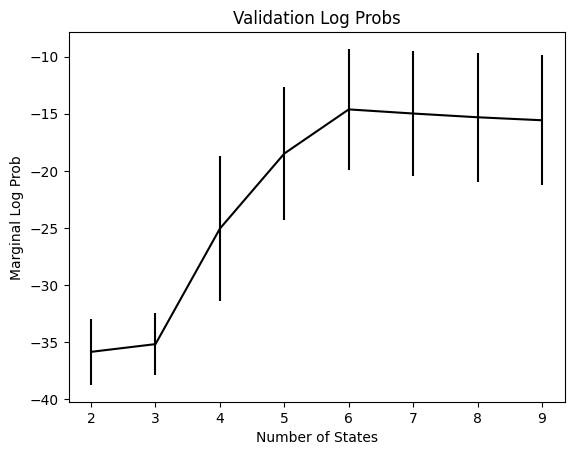

In [81]:
plt.errorbar(range(0, 8), validation_log_probs["LinearRegressionHMM"].mean(axis=1), c="k", yerr=validation_log_probs["LinearRegressionHMM"].std(axis=1))
plt.xticks(range(0, 8), range(2, 10))

plt.xlabel("Number of States")
plt.ylabel("Marginal Log Prob")
plt.title("Validation Log Probs")

plt.show()

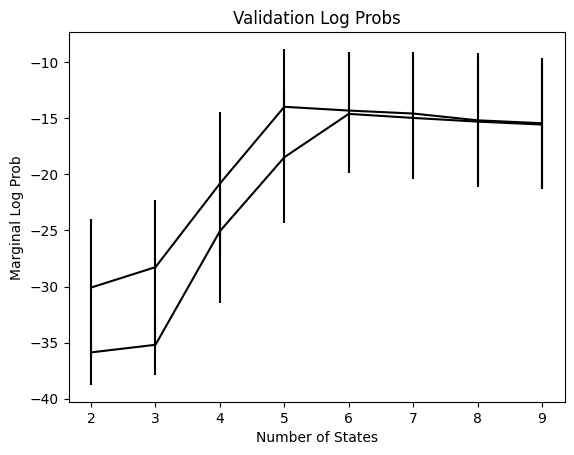

In [84]:
# plt.plot(validation_log_probs["CircHMMsT"].mean(axis=1))
plt.errorbar(range(0, 8), validation_log_probs["CircHMMsT"].mean(axis=1), c="k", yerr=validation_log_probs["CircHMMsT"].std(axis=1))
plt.errorbar(range(0, 8), validation_log_probs["LinearRegressionHMM"].mean(axis=1), c="k", yerr=validation_log_probs["LinearRegressionHMM"].std(axis=1))
plt.xticks(range(0, 8), range(2, 10))

plt.xlabel("Number of States")
plt.ylabel("Marginal Log Prob")
plt.title("Validation Log Probs")

plt.show()


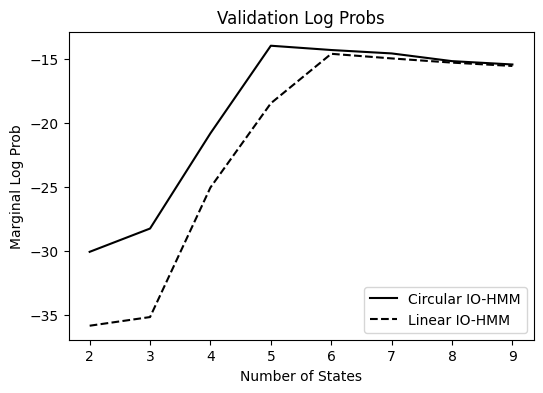

In [125]:
plt.figure(figsize=(6, 4))

plt.plot(validation_log_probs["CircHMMsT"].mean(axis=1), "k-", label="Circular IO-HMM")
plt.plot(validation_log_probs["LinearRegressionHMM"].mean(axis=1), "k--", label="Linear IO-HMM")
plt.xticks(range(0, 8), range(2, 10))

plt.legend(loc="lower right")
plt.xlabel("Number of States")
plt.ylabel("Marginal Log Prob")
plt.title("Validation Log Probs")

plt.show()


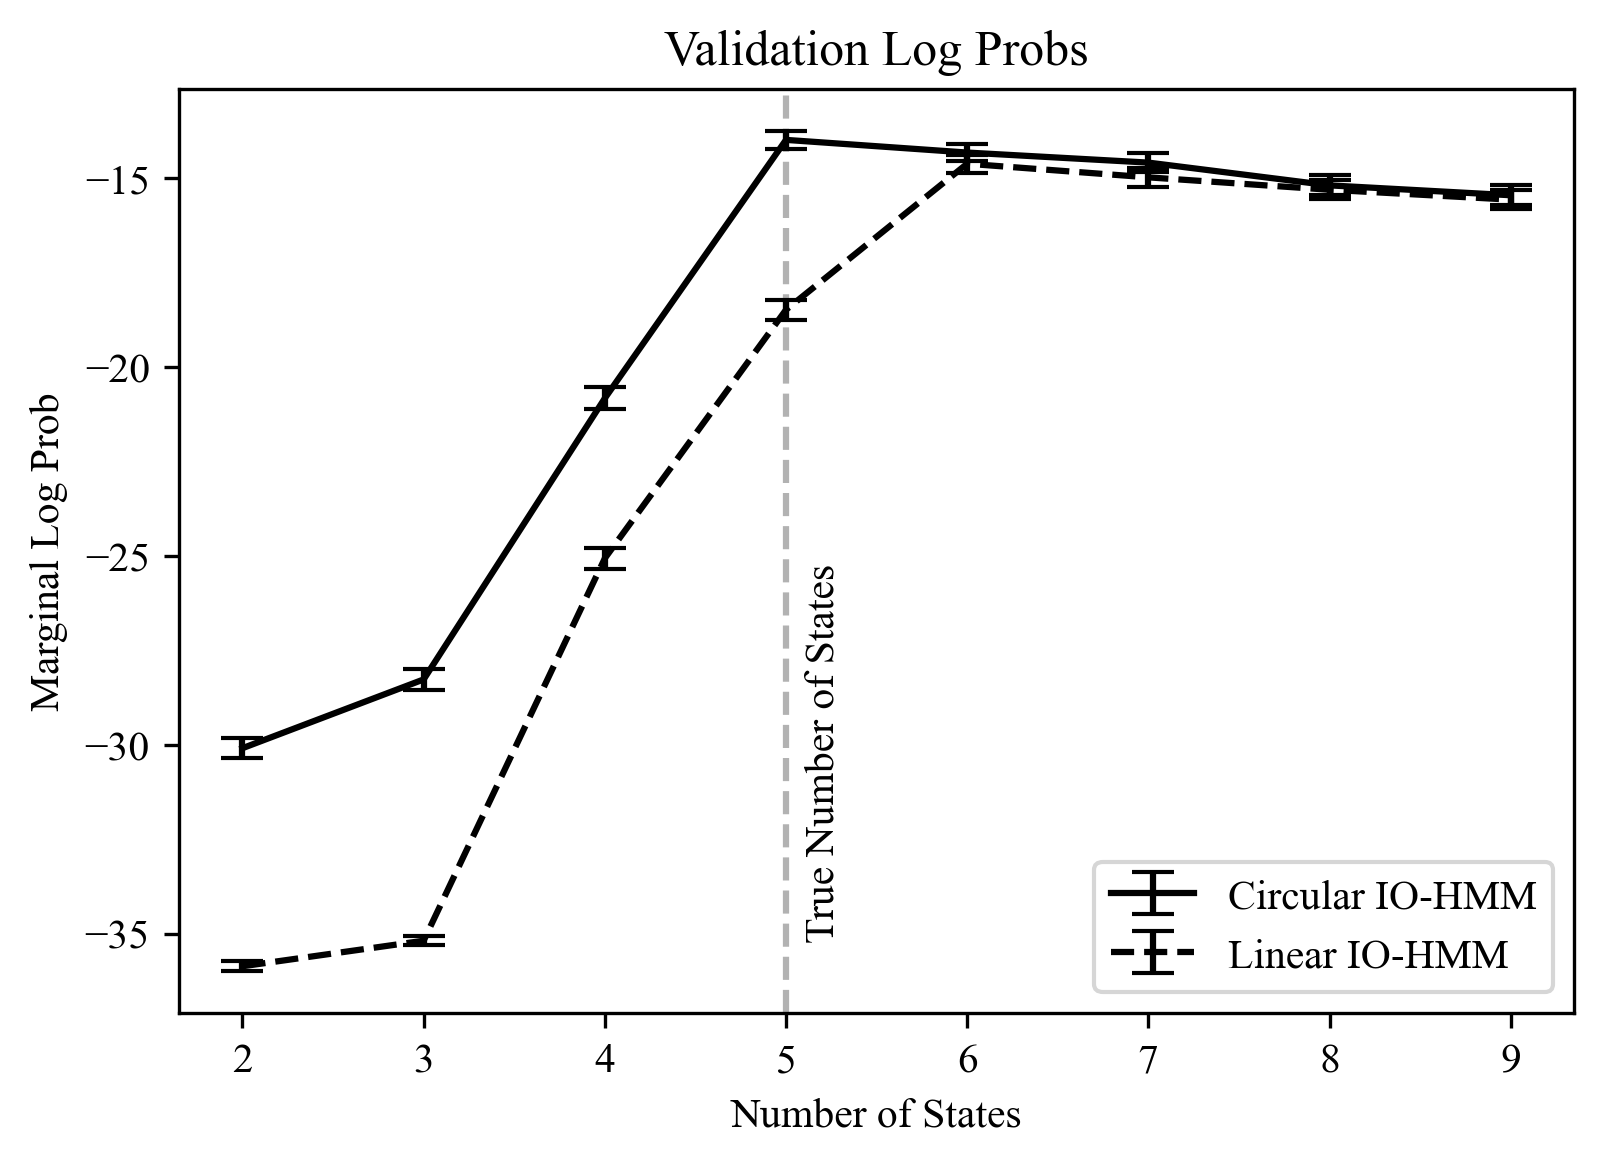

In [164]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Sample data
circ_means = validation_log_probs["CircHMMsT"].mean(axis=1)
circ_sems = stats.sem(validation_log_probs["CircHMMsT"], axis=1)

lin_means = validation_log_probs["LinearRegressionHMM"].mean(axis=1)
lin_sems = stats.sem(validation_log_probs["LinearRegressionHMM"], axis=1)

# Plot with error bars
plt.figure(figsize=(6, 4), dpi=300)

# Circular IO-HMM with SEM
plt.errorbar(range(len(circ_means)), circ_means, yerr=circ_sems, fmt="k-", label="Circular IO-HMM", capsize=5)

# Linear IO-HMM with SEM
plt.errorbar(range(len(lin_means)), lin_means, yerr=lin_sems, fmt="k--", label="Linear IO-HMM", capsize=5)

plt.xticks(range(0, 8), range(2, 10))
plt.legend(loc="lower right")
plt.xlabel("Number of States")
plt.ylabel("Marginal Log Prob")
plt.title("Validation Log Probs")

# Optionally, annotate significant points (for example, p-value < 0.05)
# plt.annotate('*', xy=(3, circ_means[3]), xytext=(3, circ_means[3]+0.1), ha='center', fontsize=12, color='black')

# put a vertical line at state 5 and label it as the True number of states
plt.axvline(x=3, color='k', linestyle='--', alpha=0.3)
plt.text(3.1, -35, 'True Number of States', rotation=90)
plt.savefig("validation_log_probs.pdf", format="pdf")


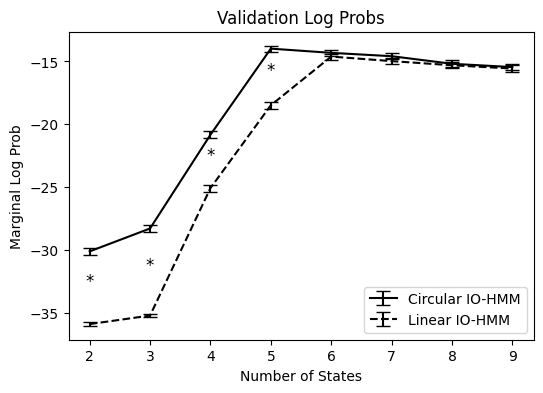

In [131]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Sample data
circ_data = validation_log_probs["CircHMMsT"]
lin_data = validation_log_probs["LinearRegressionHMM"]

circ_means = circ_data.mean(axis=1)
lin_means = lin_data.mean(axis=1)

circ_sems = stats.sem(circ_data, axis=1)
lin_sems = stats.sem(lin_data, axis=1)

# Calculate p-values at each point
p_values = []
for i in range(circ_data.shape[0]):
    _, p_value = stats.ttest_ind(circ_data[i], lin_data[i])
    p_values.append(p_value)

# Plot with error bars
plt.figure(figsize=(6, 4))

# Circular IO-HMM with SEM
plt.errorbar(range(len(circ_means)), circ_means, yerr=circ_sems, fmt="k-", label="Circular IO-HMM", capsize=5)

# Linear IO-HMM with SEM
plt.errorbar(range(len(lin_means)), lin_means, yerr=lin_sems, fmt="k--", label="Linear IO-HMM", capsize=5)

plt.xticks(range(0, 8), range(2, 10))
plt.legend(loc="lower right")
plt.xlabel("Number of States")
plt.ylabel("Marginal Log Prob")
plt.title("Validation Log Probs")

# Annotate points where p-value < 0.05 with *
for i, p_value in enumerate(p_values):
    if p_value < 0.05:
        # Annotate * at the mid-point between the two means
        mid_point = (circ_means[i] + lin_means[i]) / 2
        plt.annotate('*', xy=(i, mid_point), xytext=(i, mid_point + 0.1),
                     ha='center', fontsize=12, color='black')

plt.show()


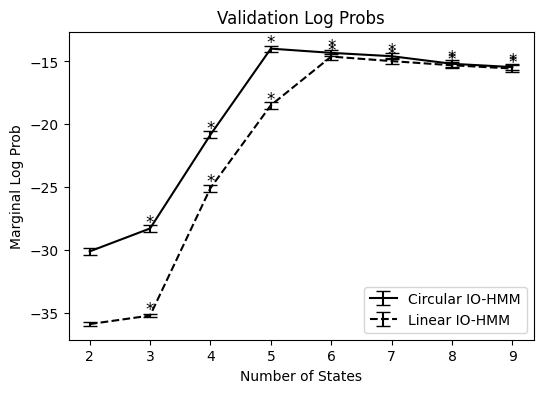

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Sample data
circ_data = validation_log_probs["CircHMMsT"]
lin_data = validation_log_probs["LinearRegressionHMM"]

circ_means = circ_data.mean(axis=1)
lin_means = lin_data.mean(axis=1)

circ_sems = stats.sem(circ_data, axis=1)
lin_sems = stats.sem(lin_data, axis=1)

# Calculate p-values for each model from the previous timestep
circ_p_values = []
lin_p_values = []

for i in range(1, circ_data.shape[0]):
    _, circ_p_value = stats.ttest_rel(circ_data[i], circ_data[i-1])  # Circular IO-HMM
    _, lin_p_value = stats.ttest_rel(lin_data[i], lin_data[i-1])    # Linear IO-HMM
    circ_p_values.append(circ_p_value)
    lin_p_values.append(lin_p_value)

# Plot with error bars
plt.figure(figsize=(6, 4))

# Circular IO-HMM with SEM
plt.errorbar(range(len(circ_means)), circ_means, yerr=circ_sems, fmt="k-", label="Circular IO-HMM", capsize=5)

# Linear IO-HMM with SEM
plt.errorbar(range(len(lin_means)), lin_means, yerr=lin_sems, fmt="k--", label="Linear IO-HMM", capsize=5)

plt.xticks(range(0, 8), range(2, 10))
plt.legend(loc="lower right")
plt.xlabel("Number of States")
plt.ylabel("Marginal Log Prob")
plt.title("Validation Log Probs")

# Annotate points where p-value < 0.05 with * for Circular IO-HMM
for i, p_value in enumerate(circ_p_values, start=1):  # start=1 to skip the first step
    if p_value < 0.05:
        # Annotate * above the current mean for Circular IO-HMM
        plt.annotate('*', xy=(i, circ_means[i]), xytext=(i, circ_means[i] + 0.1),
                     ha='center', fontsize=12, color='black')

# Annotate points where p-value < 0.05 with * for Linear IO-HMM
for i, p_value in enumerate(lin_p_values, start=1):  # start=1 to skip the first step
    if p_value < 0.05:
        # Annotate * above the current mean for Linear IO-HMM
        plt.annotate('*', xy=(i, lin_means[i]), xytext=(i, lin_means[i] + 0.1),
                     ha='center', fontsize=12, color='black')

plt.show()


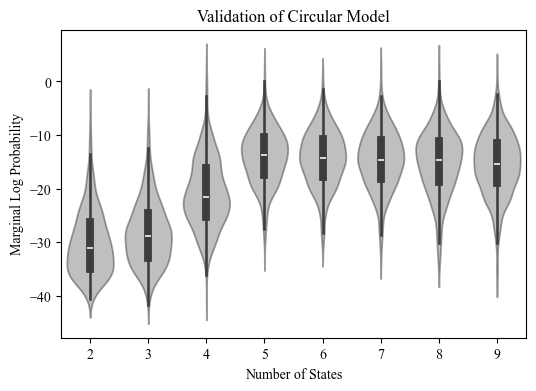

In [167]:
# make sns violin plots
plt.figure(figsize=(6, 4))
# sns.violinplot(data=validation_log_probs["CircHMMsT"].T, density_norm="width", color="gray", alpha=0.5)
sns.violinplot(data=validation_log_probs["CircHMMsT"].T, inner="box", density_norm="width", color="gray", alpha=0.5)
plt.xticks(range(0, 8), range(2, 10))
plt.xlabel("Number of States")
plt.ylabel("Marginal Log Probability")
plt.title("Validation of Circular Model")

plt.show()

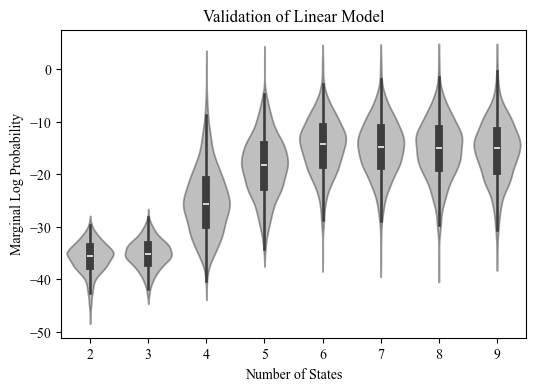

In [166]:
# make sns violin plots
plt.figure(figsize=(6, 4))
sns.violinplot(data=validation_log_probs["LinearRegressionHMM"].T, density_norm="width", color="gray", alpha=0.5)
plt.xticks(range(0, 8), range(2, 10))
plt.xlabel("Number of States")
plt.ylabel("Marginal Log Probability")
plt.title("Validation of Linear Model")

plt.show()

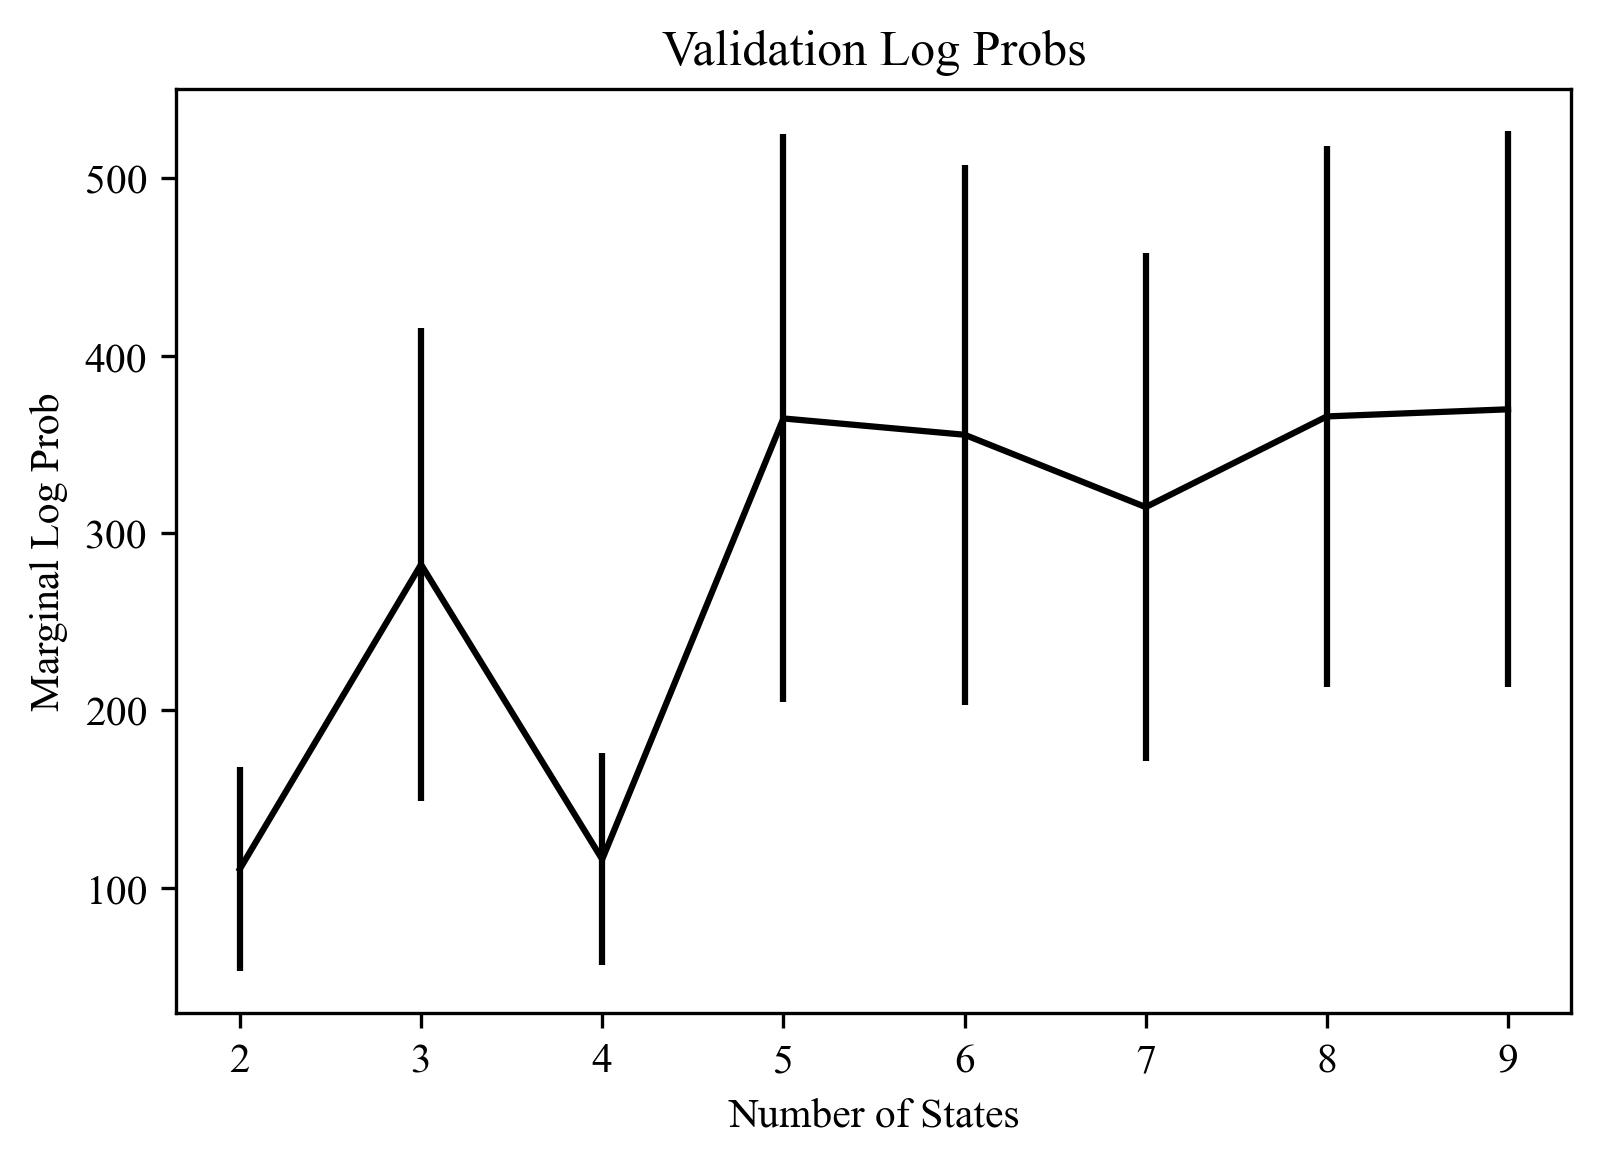

In [179]:
plt.figure(figsize=(6, 4), dpi=300)
plt.errorbar(range(0, 8), validation_log_probs["LogisticRegressionHMM"].mean(axis=1), c="k", yerr=validation_log_probs["LogisticRegressionHMM"].std(axis=1))
plt.xticks(range(0, 8), range(2, 10))

plt.xlabel("Number of States")
plt.ylabel("Marginal Log Prob")
plt.title("Validation Log Probs")

plt.show()


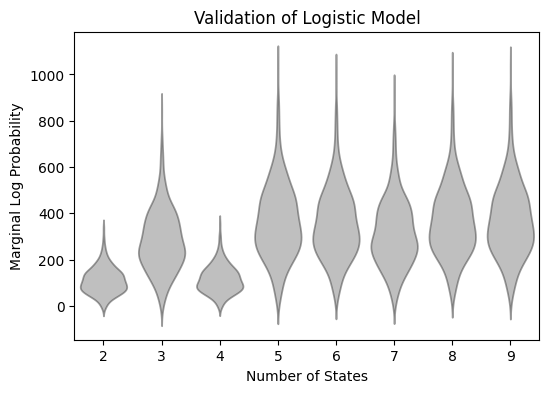

In [117]:
# make sns violin plots
plt.figure(figsize=(6, 4))
# sns.violinplot(data=validation_log_probs["CircHMMsT"].T, density_norm="width", color="gray", alpha=0.5)
sns.violinplot(data=validation_log_probs["LogisticRegressionHMM"].T, inner=None, density_norm="width", color="gray", alpha=0.5)
plt.xticks(range(0, 8), range(2, 10))
plt.xlabel("Number of States")
plt.ylabel("Marginal Log Probability")
plt.title("Validation of Logistic Model")

plt.show()

In [169]:
training_cache

defaultdict(dict,
            {'CircHMMsT': {2: <__main__.Model_Store at 0x7fe66c57af20>,
              3: <__main__.Model_Store at 0x7fe684615720>,
              4: <__main__.Model_Store at 0x7fe618345720>,
              5: <__main__.Model_Store at 0x7fe5e024e5c0>,
              6: <__main__.Model_Store at 0x7fe5a44cf1c0>,
              7: <__main__.Model_Store at 0x7fe6182bd180>,
              8: <__main__.Model_Store at 0x7fe53c6fec80>,
              9: <__main__.Model_Store at 0x7fe53c71ae60>},
             'LogisticRegressionHMM': {2: <__main__.Model_Store at 0x7fe504117bb0>,
              3: <__main__.Model_Store at 0x7fe4e5fdee60>,
              4: <__main__.Model_Store at 0x7fe4e5b9c7f0>,
              5: <__main__.Model_Store at 0x7fe504460f40>,
              6: <__main__.Model_Store at 0x7fe4e5961780>,
              7: <__main__.Model_Store at 0x7fe5046f7eb0>,
              8: <__main__.Model_Store at 0x7fe504219cf0>,
              9: <__main__.Model_Store at 0x7fe4e537fca0>}

In [171]:
true_params.transitions

ParamsStandardHMMTransitions(transition_matrix=Array([[0.66746056, 0.0275996 , 0.10142594, 0.07511953, 0.1283943 ],
       [0.03295066, 0.5235361 , 0.09683266, 0.23823701, 0.10844356],
       [0.05178186, 0.24348849, 0.4456512 , 0.1862447 , 0.07283381],
       [0.09797047, 0.04589259, 0.05409027, 0.68762887, 0.11441779],
       [0.02370666, 0.1691034 , 0.3427932 , 0.08072241, 0.38367426]],      dtype=float32))